# Question 2 - Getting Started

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

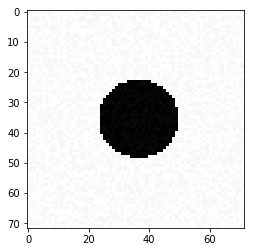

In [46]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

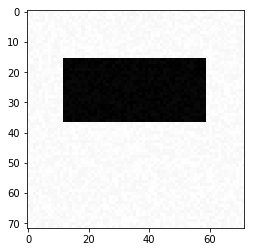

In [48]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

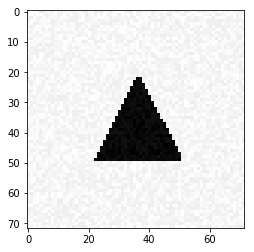

In [49]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# Question 3 - Simple Classification

In [79]:
#Imports
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

In [27]:
# Generating Training Data
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_valid, Y_valid] = generate_dataset_classification(60, 20)
Y_train = np_utils.to_categorical(Y_train)
Y_valid = np_utils.to_categorical(Y_valid)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50


##  Stochastic gradient descent optimizer

In [68]:
# Defining the Network
nb_neurons = 3
model_sgd = Sequential()
model_sgd.add(Dense(nb_neurons, activation='softmax', input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    
# Defining the Optimization Method
sgd = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
model_sgd.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Running the Optimization
model_sgd.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/1000
300/300 [==============================] - 0s - loss: 1.2946 - acc: 0.2700 - val_loss: 1.1222 - val_acc: 0.3833
Epoch 2/1000
300/300 [==============================] - 0s - loss: 1.0864 - acc: 0.4233 - val_loss: 1.1143 - val_acc: 0.4167
Epoch 3/1000
300/300 [==============================] - 0s - loss: 1.0493 - acc: 0.5100 - val_loss: 0.9236 - val_acc: 0.5000
Epoch 4/1000
300/300 [==============================] - 0s - loss: 0.8760 - acc: 0.6300 - val_loss: 0.7898 - val_acc: 0.7833
Epoch 5/1000
300/300 [==============================] - 0s - loss: 0.8568 - acc: 0.6267 - val_loss: 0.7784 - val_acc: 0.6667
Epoch 6/1000
300/300 [==============================] - 0s - loss: 0.7546 - acc: 0.7267 - val_loss: 0.7742 - val_acc: 0.6333
Epoch 7/1000
300/300 [==============================] - 0s - loss: 0.7266 - acc: 0.7600 - val_loss: 0.6790 - val_acc: 0.8167
Epoch 8/1000
300/300 [==============================] - 0s - loss: 0.6797 - acc:

300/300 [==============================] - 0s - loss: 0.2534 - acc: 0.9567 - val_loss: 0.2625 - val_acc: 0.9333
Epoch 66/1000
300/300 [==============================] - 0s - loss: 0.2571 - acc: 0.9533 - val_loss: 0.2575 - val_acc: 0.9667
Epoch 67/1000
300/300 [==============================] - 0s - loss: 0.2488 - acc: 0.9600 - val_loss: 0.2587 - val_acc: 0.9333
Epoch 68/1000
300/300 [==============================] - 0s - loss: 0.2479 - acc: 0.9600 - val_loss: 0.2534 - val_acc: 0.9333
Epoch 69/1000
300/300 [==============================] - 0s - loss: 0.2433 - acc: 0.9600 - val_loss: 0.2742 - val_acc: 0.9000
Epoch 70/1000
300/300 [==============================] - 0s - loss: 0.2395 - acc: 0.9567 - val_loss: 0.2512 - val_acc: 1.0000
Epoch 71/1000
300/300 [==============================] - 0s - loss: 0.2387 - acc: 0.9667 - val_loss: 0.2569 - val_acc: 0.9000
Epoch 72/1000
300/300 [==============================] - 0s - loss: 0.2447 - acc: 0.9500 - val_loss: 0.2469 - val_acc: 0.9333
Epoch 

300/300 [==============================] - 0s - loss: 0.1650 - acc: 0.9700 - val_loss: 0.1685 - val_acc: 1.0000
Epoch 130/1000
300/300 [==============================] - 0s - loss: 0.1646 - acc: 0.9800 - val_loss: 0.1733 - val_acc: 0.9500
Epoch 131/1000
300/300 [==============================] - 0s - loss: 0.1595 - acc: 0.9733 - val_loss: 0.1694 - val_acc: 0.9667
Epoch 132/1000
300/300 [==============================] - 0s - loss: 0.1615 - acc: 0.9700 - val_loss: 0.1775 - val_acc: 0.9333
Epoch 133/1000
300/300 [==============================] - 0s - loss: 0.1601 - acc: 0.9800 - val_loss: 0.1664 - val_acc: 0.9833
Epoch 134/1000
300/300 [==============================] - 0s - loss: 0.1581 - acc: 0.9800 - val_loss: 0.1710 - val_acc: 0.9500
Epoch 135/1000
300/300 [==============================] - 0s - loss: 0.1551 - acc: 0.9767 - val_loss: 0.1999 - val_acc: 0.9000
Epoch 136/1000
300/300 [==============================] - 0s - loss: 0.1681 - acc: 0.9700 - val_loss: 0.1617 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.1226 - acc: 0.9900 - val_loss: 0.1419 - val_acc: 0.9500
Epoch 194/1000
300/300 [==============================] - 0s - loss: 0.1229 - acc: 0.9833 - val_loss: 0.1312 - val_acc: 0.9833
Epoch 195/1000
300/300 [==============================] - 0s - loss: 0.1199 - acc: 0.9900 - val_loss: 0.1265 - val_acc: 1.0000
Epoch 196/1000
300/300 [==============================] - 0s - loss: 0.1214 - acc: 0.9867 - val_loss: 0.1248 - val_acc: 1.0000
Epoch 197/1000
300/300 [==============================] - 0s - loss: 0.1189 - acc: 0.9933 - val_loss: 0.1431 - val_acc: 0.9500
Epoch 198/1000
300/300 [==============================] - 0s - loss: 0.1195 - acc: 0.9900 - val_loss: 0.1375 - val_acc: 0.9667
Epoch 199/1000
300/300 [==============================] - 0s - loss: 0.1166 - acc: 0.9867 - val_loss: 0.1226 - val_acc: 1.0000
Epoch 200/1000
300/300 [==============================] - 0s - loss: 0.1188 - acc: 0.9833 - val_loss: 0.1222 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0976 - acc: 0.9867 - val_loss: 0.1178 - val_acc: 0.9667
Epoch 258/1000
300/300 [==============================] - 0s - loss: 0.0974 - acc: 0.9933 - val_loss: 0.1019 - val_acc: 1.0000
Epoch 259/1000
300/300 [==============================] - 0s - loss: 0.0969 - acc: 0.9900 - val_loss: 0.1151 - val_acc: 0.9667
Epoch 260/1000
300/300 [==============================] - 0s - loss: 0.0980 - acc: 0.9833 - val_loss: 0.1009 - val_acc: 1.0000
Epoch 261/1000
300/300 [==============================] - 0s - loss: 0.0992 - acc: 0.9933 - val_loss: 0.0996 - val_acc: 1.0000
Epoch 262/1000
300/300 [==============================] - 0s - loss: 0.0971 - acc: 0.9933 - val_loss: 0.1043 - val_acc: 1.0000
Epoch 263/1000
300/300 [==============================] - 0s - loss: 0.0977 - acc: 0.9900 - val_loss: 0.1091 - val_acc: 0.9833
Epoch 264/1000
300/300 [==============================] - 0s - loss: 0.0970 - acc: 0.9867 - val_loss: 0.1021 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0817 - acc: 0.9933 - val_loss: 0.0839 - val_acc: 1.0000
Epoch 322/1000
300/300 [==============================] - 0s - loss: 0.0810 - acc: 0.9933 - val_loss: 0.0833 - val_acc: 1.0000
Epoch 323/1000
300/300 [==============================] - 0s - loss: 0.0797 - acc: 0.9967 - val_loss: 0.0928 - val_acc: 1.0000
Epoch 324/1000
300/300 [==============================] - 0s - loss: 0.0806 - acc: 0.9933 - val_loss: 0.0958 - val_acc: 0.9833
Epoch 325/1000
300/300 [==============================] - 0s - loss: 0.0809 - acc: 0.9900 - val_loss: 0.0871 - val_acc: 1.0000
Epoch 326/1000
300/300 [==============================] - 0s - loss: 0.0808 - acc: 0.9967 - val_loss: 0.0953 - val_acc: 0.9833
Epoch 327/1000
300/300 [==============================] - 0s - loss: 0.0812 - acc: 0.9900 - val_loss: 0.0906 - val_acc: 1.0000
Epoch 328/1000
300/300 [==============================] - 0s - loss: 0.0806 - acc: 0.9933 - val_loss: 0.0822 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0702 - acc: 1.0000 - val_loss: 0.0731 - val_acc: 1.0000
Epoch 386/1000
300/300 [==============================] - 0s - loss: 0.0691 - acc: 0.9967 - val_loss: 0.0774 - val_acc: 1.0000
Epoch 387/1000
300/300 [==============================] - 0s - loss: 0.0697 - acc: 0.9933 - val_loss: 0.0763 - val_acc: 1.0000
Epoch 388/1000
300/300 [==============================] - 0s - loss: 0.0688 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 1.0000
Epoch 389/1000
300/300 [==============================] - 0s - loss: 0.0686 - acc: 0.9933 - val_loss: 0.0711 - val_acc: 1.0000
Epoch 390/1000
300/300 [==============================] - 0s - loss: 0.0692 - acc: 0.9933 - val_loss: 0.0720 - val_acc: 1.0000
Epoch 391/1000
300/300 [==============================] - 0s - loss: 0.0686 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 1.0000
Epoch 392/1000
300/300 [==============================] - 0s - loss: 0.0682 - acc: 0.9967 - val_loss: 0.0767 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0608 - acc: 0.9967 - val_loss: 0.0662 - val_acc: 1.0000
Epoch 450/1000
300/300 [==============================] - 0s - loss: 0.0606 - acc: 1.0000 - val_loss: 0.0652 - val_acc: 1.0000
Epoch 451/1000
300/300 [==============================] - 0s - loss: 0.0608 - acc: 0.9967 - val_loss: 0.0622 - val_acc: 1.0000
Epoch 452/1000
300/300 [==============================] - 0s - loss: 0.0604 - acc: 0.9967 - val_loss: 0.0626 - val_acc: 1.0000
Epoch 453/1000
300/300 [==============================] - 0s - loss: 0.0596 - acc: 0.9967 - val_loss: 0.0639 - val_acc: 1.0000
Epoch 454/1000
300/300 [==============================] - 0s - loss: 0.0597 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 1.0000
Epoch 455/1000
300/300 [==============================] - 0s - loss: 0.0625 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 1.0000
Epoch 456/1000
300/300 [==============================] - 0s - loss: 0.0595 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0527 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 1.0000
Epoch 514/1000
300/300 [==============================] - 0s - loss: 0.0549 - acc: 0.9933 - val_loss: 0.0598 - val_acc: 1.0000
Epoch 515/1000
300/300 [==============================] - 0s - loss: 0.0540 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 1.0000
Epoch 516/1000
300/300 [==============================] - 0s - loss: 0.0535 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 1.0000
Epoch 517/1000
300/300 [==============================] - 0s - loss: 0.0533 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 1.0000
Epoch 518/1000
300/300 [==============================] - 0s - loss: 0.0531 - acc: 1.0000 - val_loss: 0.0585 - val_acc: 1.0000
Epoch 519/1000
300/300 [==============================] - 0s - loss: 0.0535 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 1.0000
Epoch 520/1000
300/300 [==============================] - 0s - loss: 0.0529 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0476 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 1.0000
Epoch 578/1000
300/300 [==============================] - 0s - loss: 0.0481 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 1.0000
Epoch 579/1000
300/300 [==============================] - 0s - loss: 0.0481 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 1.0000
Epoch 580/1000
300/300 [==============================] - 0s - loss: 0.0481 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 1.0000
Epoch 581/1000
300/300 [==============================] - 0s - loss: 0.0490 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 1.0000
Epoch 582/1000
300/300 [==============================] - 0s - loss: 0.0477 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 1.0000
Epoch 583/1000
300/300 [==============================] - 0s - loss: 0.0479 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 1.0000
Epoch 584/1000
300/300 [==============================] - 0s - loss: 0.0478 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0442 - acc: 1.0000 - val_loss: 0.0471 - val_acc: 1.0000
Epoch 642/1000
300/300 [==============================] - 0s - loss: 0.0440 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 1.0000
Epoch 643/1000
300/300 [==============================] - 0s - loss: 0.0435 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 1.0000
Epoch 644/1000
300/300 [==============================] - 0s - loss: 0.0434 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 1.0000
Epoch 645/1000
300/300 [==============================] - 0s - loss: 0.0436 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 1.0000
Epoch 646/1000
300/300 [==============================] - 0s - loss: 0.0439 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 1.0000
Epoch 647/1000
300/300 [==============================] - 0s - loss: 0.0442 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 1.0000
Epoch 648/1000
300/300 [==============================] - 0s - loss: 0.0440 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0411 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 1.0000
Epoch 706/1000
300/300 [==============================] - 0s - loss: 0.0399 - acc: 1.0000 - val_loss: 0.0431 - val_acc: 1.0000
Epoch 707/1000
300/300 [==============================] - 0s - loss: 0.0398 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 1.0000
Epoch 708/1000
300/300 [==============================] - 0s - loss: 0.0397 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 1.0000
Epoch 709/1000
300/300 [==============================] - 0s - loss: 0.0406 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 1.0000
Epoch 710/1000
300/300 [==============================] - 0s - loss: 0.0396 - acc: 1.0000 - val_loss: 0.0421 - val_acc: 1.0000
Epoch 711/1000
300/300 [==============================] - 0s - loss: 0.0397 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 1.0000
Epoch 712/1000
300/300 [==============================] - 0s - loss: 0.0398 - acc: 1.0000 - val_loss: 0.0437 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0369 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 1.0000
Epoch 770/1000
300/300 [==============================] - 0s - loss: 0.0370 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 1.0000
Epoch 771/1000
300/300 [==============================] - 0s - loss: 0.0367 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 1.0000
Epoch 772/1000
300/300 [==============================] - 0s - loss: 0.0367 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 1.0000
Epoch 773/1000
300/300 [==============================] - 0s - loss: 0.0368 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 1.0000
Epoch 774/1000
300/300 [==============================] - 0s - loss: 0.0367 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 1.0000
Epoch 775/1000
300/300 [==============================] - 0s - loss: 0.0367 - acc: 1.0000 - val_loss: 0.0399 - val_acc: 1.0000
Epoch 776/1000
300/300 [==============================] - 0s - loss: 0.0369 - acc: 1.0000 - val_loss: 0.0400 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0342 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 1.0000
Epoch 834/1000
300/300 [==============================] - 0s - loss: 0.0344 - acc: 1.0000 - val_loss: 0.0369 - val_acc: 1.0000
Epoch 835/1000
300/300 [==============================] - 0s - loss: 0.0348 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 1.0000
Epoch 836/1000
300/300 [==============================] - 0s - loss: 0.0344 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 1.0000
Epoch 837/1000
300/300 [==============================] - 0s - loss: 0.0338 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 1.0000
Epoch 838/1000
300/300 [==============================] - 0s - loss: 0.0342 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 1.0000
Epoch 839/1000
300/300 [==============================] - 0s - loss: 0.0342 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 1.0000
Epoch 840/1000
300/300 [==============================] - 0s - loss: 0.0339 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0319 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 1.0000
Epoch 898/1000
300/300 [==============================] - 0s - loss: 0.0318 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 1.0000
Epoch 899/1000
300/300 [==============================] - 0s - loss: 0.0320 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 1.0000
Epoch 900/1000
300/300 [==============================] - 0s - loss: 0.0318 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 1.0000
Epoch 901/1000
300/300 [==============================] - 0s - loss: 0.0317 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 1.0000
Epoch 902/1000
300/300 [==============================] - 0s - loss: 0.0317 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 1.0000
Epoch 903/1000
300/300 [==============================] - 0s - loss: 0.0316 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 1.0000
Epoch 904/1000
300/300 [==============================] - 0s - loss: 0.0316 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 1.0000

300/300 [==============================] - 0s - loss: 0.0298 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 1.0000
Epoch 962/1000
300/300 [==============================] - 0s - loss: 0.0298 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 1.0000
Epoch 963/1000
300/300 [==============================] - 0s - loss: 0.0298 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 1.0000
Epoch 964/1000
300/300 [==============================] - 0s - loss: 0.0299 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 1.0000
Epoch 965/1000
300/300 [==============================] - 0s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 1.0000
Epoch 966/1000
300/300 [==============================] - 0s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 1.0000
Epoch 967/1000
300/300 [==============================] - 0s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 1.0000
Epoch 968/1000
300/300 [==============================] - 0s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.0313 - val_acc: 1.0000

In [69]:
# Evaluate
print("\n", "model evaluate: ", model_sgd.evaluate(X_valid, Y_valid, batch_size = 32, verbose =1000),"\n")


 model evaluate:  [0.031025312592585882, 1.0] 



## Adam optimizer

In [63]:
# Defining the Network
nb_neurons = 3
model_adam = Sequential()
model_adam.add(Dense(nb_neurons, activation='softmax', input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    
# Defining the Optimization Method
model_adam.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Running the Optimization
model_adam.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/100
300/300 [==============================] - 0s - loss: 1.7340 - acc: 0.4233 - val_loss: 1.2486 - val_acc: 0.5167
Epoch 2/100
300/300 [==============================] - 0s - loss: 0.7973 - acc: 0.7033 - val_loss: 0.5855 - val_acc: 0.7333
Epoch 3/100
300/300 [==============================] - 0s - loss: 0.5095 - acc: 0.7867 - val_loss: 0.4318 - val_acc: 0.9167
Epoch 4/100
300/300 [==============================] - 0s - loss: 0.4350 - acc: 0.8333 - val_loss: 0.5927 - val_acc: 0.6000
Epoch 5/100
300/300 [==============================] - 0s - loss: 0.3955 - acc: 0.8167 - val_loss: 0.3923 - val_acc: 0.9000
Epoch 6/100
300/300 [==============================] - 0s - loss: 0.3278 - acc: 0.8800 - val_loss: 0.3545 - val_acc: 0.7667
Epoch 7/100
300/300 [==============================] - 0s - loss: 0.3523 - acc: 0.8200 - val_loss: 0.4524 - val_acc: 0.7667
Epoch 8/100
300/300 [==============================] - 0s - loss: 0.3398 - acc: 0.8300 

300/300 [==============================] - 0s - loss: 0.0156 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 1.0000
Epoch 66/100
300/300 [==============================] - 0s - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 1.0000
Epoch 67/100
300/300 [==============================] - 0s - loss: 0.0144 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 1.0000
Epoch 68/100
300/300 [==============================] - 0s - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 1.0000
Epoch 69/100
300/300 [==============================] - 0s - loss: 0.0155 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 1.0000
Epoch 70/100
300/300 [==============================] - 0s - loss: 0.0148 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 1.0000
Epoch 71/100
300/300 [==============================] - 0s - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 1.0000
Epoch 72/100
300/300 [==============================] - 0s - loss: 0.0129 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 1.0000
Epoch 73/100


In [64]:
# Evaluate
print("\n", "model evaluate: ", model_adam.evaluate(X_valid, Y_valid, batch_size = 32, verbose =1000),"\n")


 model evaluate:  [0.00820155485222737, 1.0] 



# Question 4 - Visualization of the Solution


In [65]:
def visualize_column(model):
    weights = model.get_weights()[0]
    weights = weights.reshape(IMAGE_SIZE, IMAGE_SIZE, weights.shape[1])
    _, [ax0, ax1, ax2] = plt.subplots(1, 3)
    ax0.imshow(weights[:,:,0], cmap='gray')
    ax1.imshow(weights[:,:,1], cmap='gray')
    ax2.imshow(weights[:,:,2], cmap='gray')

## Stochastic gradient descent optimizer

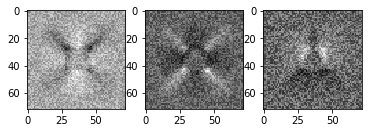

In [70]:
visualize_column(model_sgd)

## Adam optimizer

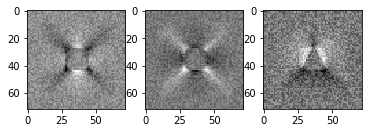

In [67]:
visualize_column(model_adam)

# Question 5 - A More Difficult Classification Problem

In [83]:
# Generating New Training Data
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_valid, Y_valid] = generate_dataset_classification(60, 20, True)
Y_train = np_utils.to_categorical(Y_train)
Y_valid = np_utils.to_categorical(Y_valid)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50


## Stochastic gradient descent optimizer

In [84]:
# Running the Optimization
model_sgd.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/1000
300/300 [==============================] - 0s - loss: 0.9047 - acc: 0.6000 - val_loss: 0.8309 - val_acc: 0.5833
Epoch 2/1000
300/300 [==============================] - 0s - loss: 0.8952 - acc: 0.5733 - val_loss: 0.7402 - val_acc: 0.6333
Epoch 3/1000
300/300 [==============================] - 0s - loss: 0.8860 - acc: 0.6033 - val_loss: 0.6956 - val_acc: 0.7000
Epoch 4/1000
300/300 [==============================] - 0s - loss: 0.8995 - acc: 0.6000 - val_loss: 0.8727 - val_acc: 0.5667
Epoch 5/1000
300/300 [==============================] - 0s - loss: 0.9016 - acc: 0.5933 - val_loss: 0.7602 - val_acc: 0.6333
Epoch 6/1000
300/300 [==============================] - 0s - loss: 0.8621 - acc: 0.6033 - val_loss: 0.6954 - val_acc: 0.6833
Epoch 7/1000
300/300 [==============================] - 0s - loss: 0.9107 - acc: 0.5933 - val_loss: 0.6930 - val_acc: 0.7000
Epoch 8/1000
300/300 [==============================] - 0s - loss: 0.8615 - acc:

300/300 [==============================] - 0s - loss: 0.7488 - acc: 0.6600 - val_loss: 0.7412 - val_acc: 0.6167
Epoch 66/1000
300/300 [==============================] - 0s - loss: 0.7788 - acc: 0.6567 - val_loss: 0.8111 - val_acc: 0.6167
Epoch 67/1000
300/300 [==============================] - 0s - loss: 0.7286 - acc: 0.6500 - val_loss: 0.6246 - val_acc: 0.7000
Epoch 68/1000
300/300 [==============================] - 0s - loss: 0.7591 - acc: 0.6500 - val_loss: 0.6101 - val_acc: 0.7333
Epoch 69/1000
300/300 [==============================] - 0s - loss: 0.7319 - acc: 0.6533 - val_loss: 0.8046 - val_acc: 0.6000
Epoch 70/1000
300/300 [==============================] - 0s - loss: 0.7336 - acc: 0.6500 - val_loss: 0.6066 - val_acc: 0.7000
Epoch 71/1000
300/300 [==============================] - 0s - loss: 0.7677 - acc: 0.6533 - val_loss: 0.6533 - val_acc: 0.6667
Epoch 72/1000
300/300 [==============================] - 0s - loss: 0.7279 - acc: 0.6733 - val_loss: 0.6032 - val_acc: 0.7333
Epoch 

300/300 [==============================] - 0s - loss: 0.7141 - acc: 0.6667 - val_loss: 0.6307 - val_acc: 0.7167
Epoch 130/1000
300/300 [==============================] - 0s - loss: 0.6825 - acc: 0.7100 - val_loss: 0.8161 - val_acc: 0.6000
Epoch 131/1000
300/300 [==============================] - 0s - loss: 0.6969 - acc: 0.7000 - val_loss: 0.5982 - val_acc: 0.7000
Epoch 132/1000
300/300 [==============================] - 0s - loss: 0.6768 - acc: 0.6800 - val_loss: 0.5905 - val_acc: 0.7333
Epoch 133/1000
300/300 [==============================] - 0s - loss: 0.7131 - acc: 0.6567 - val_loss: 0.6202 - val_acc: 0.7000
Epoch 134/1000
300/300 [==============================] - 0s - loss: 0.6751 - acc: 0.7133 - val_loss: 0.5926 - val_acc: 0.6833
Epoch 135/1000
300/300 [==============================] - 0s - loss: 0.6641 - acc: 0.7033 - val_loss: 0.6370 - val_acc: 0.6333
Epoch 136/1000
300/300 [==============================] - 0s - loss: 0.6733 - acc: 0.7067 - val_loss: 0.6568 - val_acc: 0.6667

300/300 [==============================] - 0s - loss: 0.6300 - acc: 0.7167 - val_loss: 0.5936 - val_acc: 0.7500
Epoch 194/1000
300/300 [==============================] - 0s - loss: 0.6676 - acc: 0.6867 - val_loss: 0.6086 - val_acc: 0.6667
Epoch 195/1000
300/300 [==============================] - 0s - loss: 0.6265 - acc: 0.7200 - val_loss: 0.6159 - val_acc: 0.7333
Epoch 196/1000
300/300 [==============================] - 0s - loss: 0.6150 - acc: 0.7400 - val_loss: 0.7042 - val_acc: 0.6500
Epoch 197/1000
300/300 [==============================] - 0s - loss: 0.6303 - acc: 0.7267 - val_loss: 0.6655 - val_acc: 0.6833
Epoch 198/1000
300/300 [==============================] - 0s - loss: 0.6263 - acc: 0.7400 - val_loss: 0.6322 - val_acc: 0.6833
Epoch 199/1000
300/300 [==============================] - 0s - loss: 0.6180 - acc: 0.7167 - val_loss: 0.6997 - val_acc: 0.7000
Epoch 200/1000
300/300 [==============================] - 0s - loss: 0.6300 - acc: 0.7333 - val_loss: 0.5853 - val_acc: 0.7000

300/300 [==============================] - 0s - loss: 0.5720 - acc: 0.7500 - val_loss: 0.7506 - val_acc: 0.6500
Epoch 258/1000
300/300 [==============================] - 0s - loss: 0.5914 - acc: 0.7400 - val_loss: 0.6112 - val_acc: 0.7167
Epoch 259/1000
300/300 [==============================] - 0s - loss: 0.5630 - acc: 0.7567 - val_loss: 0.8752 - val_acc: 0.6167
Epoch 260/1000
300/300 [==============================] - 0s - loss: 0.5856 - acc: 0.7500 - val_loss: 0.6410 - val_acc: 0.6833
Epoch 261/1000
300/300 [==============================] - 0s - loss: 0.5852 - acc: 0.7333 - val_loss: 0.6493 - val_acc: 0.6833
Epoch 262/1000
300/300 [==============================] - 0s - loss: 0.5887 - acc: 0.7167 - val_loss: 0.7286 - val_acc: 0.6667
Epoch 263/1000
300/300 [==============================] - 0s - loss: 0.5739 - acc: 0.7500 - val_loss: 0.6773 - val_acc: 0.7167
Epoch 264/1000
300/300 [==============================] - 0s - loss: 0.5817 - acc: 0.7267 - val_loss: 0.6681 - val_acc: 0.6333

300/300 [==============================] - 0s - loss: 0.5555 - acc: 0.7533 - val_loss: 0.6462 - val_acc: 0.6667
Epoch 322/1000
300/300 [==============================] - 0s - loss: 0.5444 - acc: 0.7767 - val_loss: 1.0418 - val_acc: 0.5667
Epoch 323/1000
300/300 [==============================] - 0s - loss: 0.5448 - acc: 0.7733 - val_loss: 0.5855 - val_acc: 0.7167
Epoch 324/1000
300/300 [==============================] - 0s - loss: 0.5430 - acc: 0.7900 - val_loss: 0.6086 - val_acc: 0.6667
Epoch 325/1000
300/300 [==============================] - 0s - loss: 0.5359 - acc: 0.7767 - val_loss: 0.6409 - val_acc: 0.7167
Epoch 326/1000
300/300 [==============================] - 0s - loss: 0.5498 - acc: 0.7733 - val_loss: 0.9405 - val_acc: 0.6000
Epoch 327/1000
300/300 [==============================] - 0s - loss: 0.5684 - acc: 0.7400 - val_loss: 0.6230 - val_acc: 0.6667
Epoch 328/1000
300/300 [==============================] - 0s - loss: 0.5540 - acc: 0.7633 - val_loss: 0.6594 - val_acc: 0.6667

300/300 [==============================] - 0s - loss: 0.5238 - acc: 0.7667 - val_loss: 0.7360 - val_acc: 0.6667
Epoch 386/1000
300/300 [==============================] - 0s - loss: 0.5145 - acc: 0.7900 - val_loss: 0.5960 - val_acc: 0.6833
Epoch 387/1000
300/300 [==============================] - 0s - loss: 0.5281 - acc: 0.7833 - val_loss: 0.5896 - val_acc: 0.7000
Epoch 388/1000
300/300 [==============================] - 0s - loss: 0.5219 - acc: 0.7800 - val_loss: 0.6759 - val_acc: 0.7000
Epoch 389/1000
300/300 [==============================] - 0s - loss: 0.5227 - acc: 0.7900 - val_loss: 0.5815 - val_acc: 0.7167
Epoch 390/1000
300/300 [==============================] - 0s - loss: 0.5076 - acc: 0.7700 - val_loss: 0.6882 - val_acc: 0.7000
Epoch 391/1000
300/300 [==============================] - 0s - loss: 0.5074 - acc: 0.8000 - val_loss: 0.6565 - val_acc: 0.7167
Epoch 392/1000
300/300 [==============================] - 0s - loss: 0.5092 - acc: 0.7767 - val_loss: 0.6085 - val_acc: 0.6833

300/300 [==============================] - 0s - loss: 0.4735 - acc: 0.8200 - val_loss: 0.6064 - val_acc: 0.6667
Epoch 450/1000
300/300 [==============================] - 0s - loss: 0.4983 - acc: 0.8000 - val_loss: 0.5980 - val_acc: 0.7000
Epoch 451/1000
300/300 [==============================] - 0s - loss: 0.4894 - acc: 0.7867 - val_loss: 0.7464 - val_acc: 0.6667
Epoch 452/1000
300/300 [==============================] - 0s - loss: 0.5039 - acc: 0.8033 - val_loss: 0.5992 - val_acc: 0.7500
Epoch 453/1000
300/300 [==============================] - 0s - loss: 0.5114 - acc: 0.7600 - val_loss: 0.8368 - val_acc: 0.6500
Epoch 454/1000
300/300 [==============================] - 0s - loss: 0.4910 - acc: 0.8000 - val_loss: 0.5821 - val_acc: 0.7000
Epoch 455/1000
300/300 [==============================] - 0s - loss: 0.4776 - acc: 0.8133 - val_loss: 0.5834 - val_acc: 0.7167
Epoch 456/1000
300/300 [==============================] - 0s - loss: 0.4676 - acc: 0.8100 - val_loss: 0.7688 - val_acc: 0.6333

300/300 [==============================] - 0s - loss: 0.4838 - acc: 0.7933 - val_loss: 0.6008 - val_acc: 0.6833
Epoch 514/1000
300/300 [==============================] - 0s - loss: 0.4687 - acc: 0.8167 - val_loss: 0.7717 - val_acc: 0.6667
Epoch 515/1000
300/300 [==============================] - 0s - loss: 0.4725 - acc: 0.8100 - val_loss: 0.6260 - val_acc: 0.6833
Epoch 516/1000
300/300 [==============================] - 0s - loss: 0.4521 - acc: 0.8300 - val_loss: 0.7145 - val_acc: 0.6667
Epoch 517/1000
300/300 [==============================] - 0s - loss: 0.4679 - acc: 0.8067 - val_loss: 0.6160 - val_acc: 0.6833
Epoch 518/1000
300/300 [==============================] - 0s - loss: 0.5028 - acc: 0.7800 - val_loss: 0.6122 - val_acc: 0.7333
Epoch 519/1000
300/300 [==============================] - 0s - loss: 0.4819 - acc: 0.7967 - val_loss: 0.7785 - val_acc: 0.6667
Epoch 520/1000
300/300 [==============================] - 0s - loss: 0.4516 - acc: 0.8300 - val_loss: 0.5812 - val_acc: 0.7333

300/300 [==============================] - 0s - loss: 0.4471 - acc: 0.8133 - val_loss: 0.6295 - val_acc: 0.7167
Epoch 578/1000
300/300 [==============================] - 0s - loss: 0.4669 - acc: 0.8100 - val_loss: 0.5839 - val_acc: 0.7333
Epoch 579/1000
300/300 [==============================] - 0s - loss: 0.4411 - acc: 0.8233 - val_loss: 0.5911 - val_acc: 0.7333
Epoch 580/1000
300/300 [==============================] - 0s - loss: 0.4406 - acc: 0.8267 - val_loss: 0.6121 - val_acc: 0.7167
Epoch 581/1000
300/300 [==============================] - 0s - loss: 0.4327 - acc: 0.8267 - val_loss: 0.6756 - val_acc: 0.7167
Epoch 582/1000
300/300 [==============================] - 0s - loss: 0.4726 - acc: 0.8167 - val_loss: 0.6093 - val_acc: 0.7167
Epoch 583/1000
300/300 [==============================] - 0s - loss: 0.4318 - acc: 0.8267 - val_loss: 0.7163 - val_acc: 0.6500
Epoch 584/1000
300/300 [==============================] - 0s - loss: 0.4474 - acc: 0.8133 - val_loss: 0.5906 - val_acc: 0.6833

300/300 [==============================] - 0s - loss: 0.4096 - acc: 0.8633 - val_loss: 0.6205 - val_acc: 0.7000
Epoch 642/1000
300/300 [==============================] - 0s - loss: 0.4125 - acc: 0.8667 - val_loss: 0.5922 - val_acc: 0.7000
Epoch 643/1000
300/300 [==============================] - 0s - loss: 0.4186 - acc: 0.8567 - val_loss: 0.8298 - val_acc: 0.6000
Epoch 644/1000
300/300 [==============================] - 0s - loss: 0.4275 - acc: 0.8467 - val_loss: 0.6091 - val_acc: 0.7000
Epoch 645/1000
300/300 [==============================] - 0s - loss: 0.4270 - acc: 0.8467 - val_loss: 0.5935 - val_acc: 0.7000
Epoch 646/1000
300/300 [==============================] - 0s - loss: 0.4335 - acc: 0.8467 - val_loss: 0.5882 - val_acc: 0.6833
Epoch 647/1000
300/300 [==============================] - 0s - loss: 0.4400 - acc: 0.8333 - val_loss: 0.5795 - val_acc: 0.7333
Epoch 648/1000
300/300 [==============================] - 0s - loss: 0.4197 - acc: 0.8000 - val_loss: 0.5820 - val_acc: 0.6833

300/300 [==============================] - 0s - loss: 0.3933 - acc: 0.8767 - val_loss: 0.7510 - val_acc: 0.6500
Epoch 706/1000
300/300 [==============================] - 0s - loss: 0.4066 - acc: 0.8500 - val_loss: 0.6010 - val_acc: 0.7167
Epoch 707/1000
300/300 [==============================] - 0s - loss: 0.4206 - acc: 0.8400 - val_loss: 0.7633 - val_acc: 0.6333
Epoch 708/1000
300/300 [==============================] - 0s - loss: 0.4186 - acc: 0.8367 - val_loss: 0.6236 - val_acc: 0.7333
Epoch 709/1000
300/300 [==============================] - 0s - loss: 0.4266 - acc: 0.8567 - val_loss: 0.7229 - val_acc: 0.6500
Epoch 710/1000
300/300 [==============================] - 0s - loss: 0.4044 - acc: 0.8533 - val_loss: 0.7372 - val_acc: 0.6333
Epoch 711/1000
300/300 [==============================] - 0s - loss: 0.4003 - acc: 0.8567 - val_loss: 0.6134 - val_acc: 0.7000
Epoch 712/1000
300/300 [==============================] - 0s - loss: 0.3959 - acc: 0.8667 - val_loss: 0.7327 - val_acc: 0.6500

KeyboardInterrupt: 

In [86]:
# Evaluate
print("\n", "model evaluate: ", model_sgd.evaluate(X_valid, Y_valid, batch_size = 32, verbose =1000),"\n")


 model evaluate:  [0.6282685359319051, 0.7333333293596903] 



## Adam optimizer

In [74]:
# Running the Optimization
model_adam.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/100
300/300 [==============================] - 0s - loss: 3.7522 - acc: 0.3300 - val_loss: 2.5185 - val_acc: 0.3167
Epoch 2/100
300/300 [==============================] - 0s - loss: 2.9022 - acc: 0.3567 - val_loss: 2.3779 - val_acc: 0.4333
Epoch 3/100
300/300 [==============================] - 0s - loss: 3.9205 - acc: 0.4033 - val_loss: 3.2134 - val_acc: 0.2833
Epoch 4/100
300/300 [==============================] - 0s - loss: 2.3004 - acc: 0.4433 - val_loss: 2.2630 - val_acc: 0.3833
Epoch 5/100
300/300 [==============================] - 0s - loss: 1.8265 - acc: 0.4767 - val_loss: 2.1728 - val_acc: 0.5000
Epoch 6/100
300/300 [==============================] - 0s - loss: 1.9422 - acc: 0.4400 - val_loss: 2.1581 - val_acc: 0.4333
Epoch 7/100
300/300 [==============================] - 0s - loss: 1.7917 - acc: 0.4667 - val_loss: 1.7119 - val_acc: 0.3667
Epoch 8/100
300/300 [==============================] - 0s - loss: 1.5398 - acc: 0.4733 

300/300 [==============================] - 0s - loss: 0.4514 - acc: 0.8167 - val_loss: 1.2915 - val_acc: 0.3833
Epoch 66/100
300/300 [==============================] - 0s - loss: 0.5237 - acc: 0.7800 - val_loss: 1.0692 - val_acc: 0.4333
Epoch 67/100
300/300 [==============================] - 0s - loss: 0.4010 - acc: 0.8600 - val_loss: 1.1001 - val_acc: 0.5667
Epoch 68/100
300/300 [==============================] - 0s - loss: 0.4141 - acc: 0.8333 - val_loss: 1.0849 - val_acc: 0.4833
Epoch 69/100
300/300 [==============================] - 0s - loss: 0.4085 - acc: 0.8500 - val_loss: 0.9834 - val_acc: 0.4833
Epoch 70/100
300/300 [==============================] - 0s - loss: 0.3913 - acc: 0.8400 - val_loss: 1.0206 - val_acc: 0.5167
Epoch 71/100
300/300 [==============================] - 0s - loss: 0.3780 - acc: 0.8667 - val_loss: 0.9978 - val_acc: 0.5667
Epoch 72/100
300/300 [==============================] - 0s - loss: 0.3668 - acc: 0.8600 - val_loss: 1.1246 - val_acc: 0.5667
Epoch 73/100


In [85]:
# Evaluate
print("\n", "model evaluate: ", model_adam.evaluate(X_valid, Y_valid, batch_size = 32, verbose =1000),"\n")


 model evaluate:  [0.6903760552406311, 0.6333333412806194] 



## Convolutional network

In [104]:
#Test data
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [111]:
#Reshape data
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_valid = X_valid.reshape(X_valid.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [131]:
#Defining the network
model_conv = Sequential()
model_conv.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model_conv.add(MaxPooling2D((2, 2)))
model_conv.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D((2, 2)))

model_conv.add(Flatten())
model_conv.add(Dense(1024, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(3, activation='softmax'))

# Defining the Optimization Method
model_conv.compile(loss='categorical_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])

# Running the Optimization
model_conv.fit(X_train, Y_train, epochs=60, batch_size=16, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/60
300/300 [==============================] - 8s - loss: 1.0922 - acc: 0.4000 - val_loss: 1.1249 - val_acc: 0.2667
Epoch 2/60
300/300 [==============================] - 8s - loss: 1.1035 - acc: 0.4000 - val_loss: 1.0906 - val_acc: 0.4667
Epoch 3/60
300/300 [==============================] - 7s - loss: 1.0825 - acc: 0.3867 - val_loss: 1.0736 - val_acc: 0.4500
Epoch 4/60
300/300 [==============================] - 8s - loss: 1.0569 - acc: 0.4633 - val_loss: 1.0778 - val_acc: 0.4000
Epoch 5/60
300/300 [==============================] - 6s - loss: 1.0213 - acc: 0.5033 - val_loss: 1.0554 - val_acc: 0.5000
Epoch 6/60
300/300 [==============================] - 6s - loss: 1.0110 - acc: 0.5033 - val_loss: 1.0609 - val_acc: 0.4000
Epoch 7/60
300/300 [==============================] - 9s - loss: 1.0339 - acc: 0.4967 - val_loss: 1.0171 - val_acc: 0.5333
Epoch 8/60
300/300 [==============================] - 9s - loss: 1.0011 - acc: 0.5433 - val_lo

In [133]:
# Evaluate
print("\n", "model evaluate: ", model_conv.evaluate(X_test, Y_test, batch_size = 32, verbose =1000),"\n")


 model evaluate:  [0.6573772152264913, 0.73] 



# Question 6 - A Regression Problem

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590


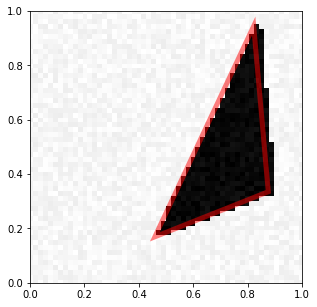

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [151]:
[X_train, Y_train] = generate_dataset_regression(600, 20)
visualize_prediction(X_train[0], Y_train[0])

[X_test, Y_test] = generate_test_set_regression()
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_valid = X_valid.reshape(X_valid.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [143]:
model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(6))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
600/600 [==============================] - 2s - loss: 23.9324 - acc: 0.1617     
Epoch 2/100
600/600 [==============================] - 2s - loss: 23.8715 - acc: 0.1550     
Epoch 3/100
600/600 [==============================] - 2s - loss: 23.8715 - acc: 0.1633     
Epoch 4/100
600/600 [==============================] - 2s - loss: 23.8715 - acc: 0.1700     
Epoch 5/100
600/600 [==============================] - 2s - loss: 23.8715 - acc: 0.1717     
Epoch 6/100
600/600 [==============================] - 1s - loss: 23.8715 - acc: 0.1550     
Epoch 7/100
600/600 [==============================] - 1s - loss: 23.8715 - acc: 0.1633     
Epoch 8/100
600/600 [==============================] - 2s - loss: 23.8715 - acc: 0.1583     
Epoch 9/100
600/600 [==============================] - 2s - loss: 23.8715 - acc: 0.1583     
Epoch 10/100
600/600 [==============================] - 2s - loss: 23.8715 - acc: 0.1617     
Epoch 11/100
600/600 [==============================] - 2s - loss: 23

600/600 [==============================] - 1s - loss: 24.0998 - acc: 0.1850     
Epoch 89/100
600/600 [==============================] - 1s - loss: 24.0826 - acc: 0.1633     
Epoch 90/100
600/600 [==============================] - 2s - loss: 24.1346 - acc: 0.1750     
Epoch 91/100
600/600 [==============================] - 2s - loss: 24.5315 - acc: 0.1717     
Epoch 92/100
600/600 [==============================] - 1s - loss: 24.3575 - acc: 0.1600     
Epoch 93/100
600/600 [==============================] - 1s - loss: 24.3068 - acc: 0.1667     
Epoch 94/100
600/600 [==============================] - 1s - loss: 24.6368 - acc: 0.1733     
Epoch 95/100
600/600 [==============================] - 1s - loss: 24.4454 - acc: 0.1617     
Epoch 96/100
600/600 [==============================] - 1s - loss: 24.2342 - acc: 0.1600     
Epoch 97/100
600/600 [==============================] - 1s - loss: 24.4952 - acc: 0.1750     
Epoch 98/100
600/600 [==============================] - 1s - loss: 23.974

In [144]:
print("model evaluate: ", model.evaluate(X_test, Y_test),"\n")

288/300 [===========================>..] - ETA: 0smodel evaluate:  [24.526774190266927, 0.19333333353201548] 



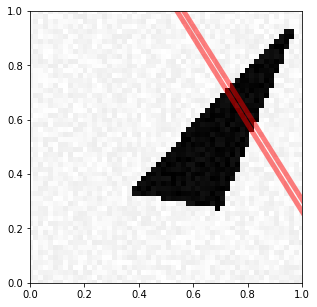

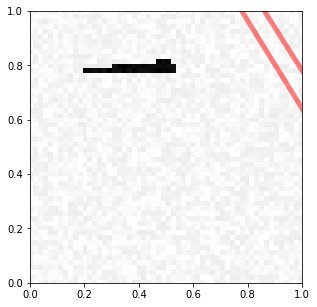

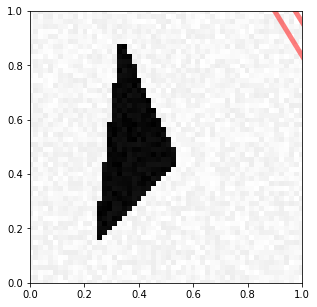

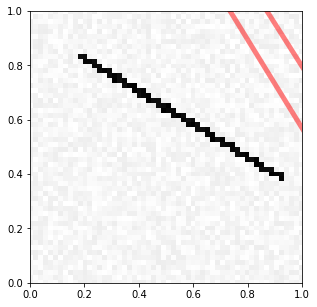

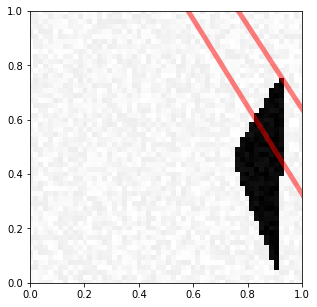

In [152]:
for i in range(0, 5):
    visualize_prediction(X_test[i], model.predict(X_test[i].reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1)))

In [155]:
# dimensions of our images.
img_width, img_height = 72, 72
nb_train_samples = 667
nb_validation_samples = 333
epochs = 50
batch_size = 16
nb_channels = 1
input_shape = (img_width, img_height,nb_channels)

model = Sequential()
model.add(Conv2D(32, (4, 4), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (4, 4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(32, (4, 4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.40))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, epochs=epochs)
print("\n", "model evaluate: ", model.evaluate(X_test, Y_test, batch_size = 32, verbose =1000),"\n")

ValueError: Error when checking model target: expected activation_21 to have shape (None, 2) but got array with shape (600, 6)